감정 사전 분석

# 샘플로 테스트

## 감정 사전 불러오기 

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 감정 사전 로딩 - NRC Emotion Lexicon
nrc_path = "../data/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
nrc = pd.read_csv(nrc_path, sep="\t", names=["word", "emotion", "association"])

# 감정 연관성 있는 단어만 필터링
nrc = nrc[nrc["association"] == 1]
print(nrc.head())
print("고유 감정 목록:", nrc["emotion"].unique())

         word   emotion  association
19     abacus     trust            1
23    abandon      fear            1
25    abandon  negative            1
27    abandon   sadness            1
30  abandoned     anger            1
고유 감정 목록: ['trust' 'fear' 'negative' 'sadness' 'anger' 'surprise' 'positive'
 'disgust' 'joy' 'anticipation']


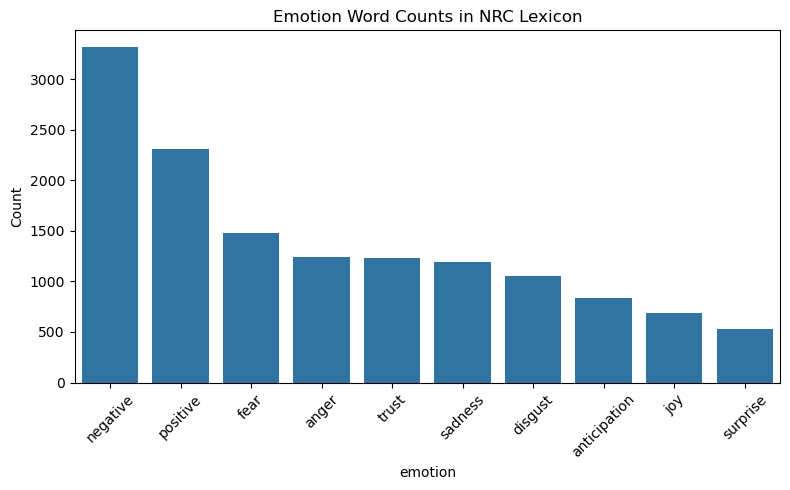

In [69]:
# 감정별 단어 수 집계 시각화
emotion_counts = nrc["emotion"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.title("Emotion Word Counts in NRC Lexicon")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* NRC 감정 사전은 joy, trust, anticipation 등 비슷한 정서가 분리돼 있어 해석이 애매한 경우가 많음
* 그래서 의미가 가까운 감정들을 love, anger, sadness 같은 감정군으로 묶어 더 직관적으로 분석할 수 있도록 구성함  
* 이 구조는 감정 점수 계산, 트렌드 분석, 클러스터링 등에 그대로 활용할 예정

## 사용자 정의 감정군으로 매핑 

In [70]:
# NRC 감정 ➜ 사용자 정의 감정군으로 매핑
custom_emotion_map = {
    "joy": "love",
    "trust": "love",
    "positive": "love",

    "sadness": "sadness",
    "fear": "sadness",
    "negative": "sadness",

    "anger": "anger",
    "disgust": "anger",

    "anticipation": "hope",
    "surprise": "surprise",
}

# 감정 단어 데이터프레임에 사용자 정의 감정군 추가
nrc["custom_emotion"] = nrc["emotion"].map(custom_emotion_map)

C:\Users\박상춘\AppData\Local\Temp\ipykernel_1980\4018467864.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group_counts.index, y=group_counts.values, palette="muted")


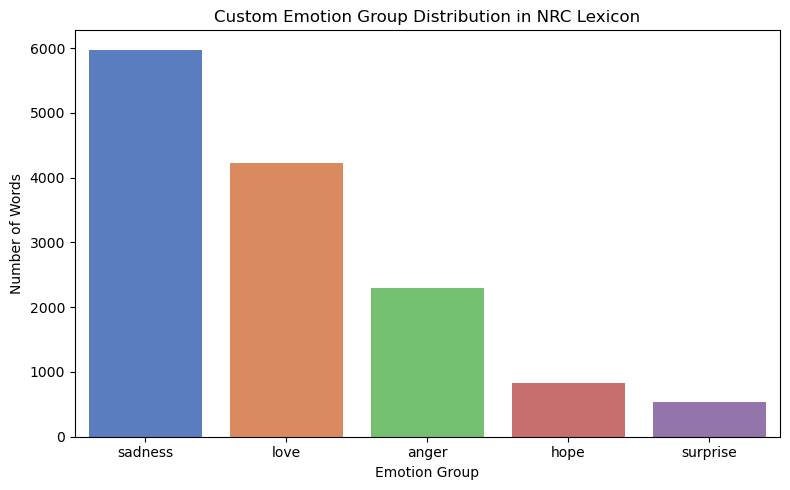

In [71]:
# 감정군별 단어 수 집계 시각화 
group_counts = nrc["custom_emotion"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=group_counts.index, y=group_counts.values, palette="muted")
plt.title("Custom Emotion Group Distribution in NRC Lexicon")
plt.ylabel("Number of Words")
plt.xlabel("Emotion Group")
plt.tight_layout()
plt.show()

In [ ]:
# 단어 기준 감정군 set 생성
word_to_emotions = (
    nrc.groupby("word")["custom_emotion"]
    .apply(set)
    .to_dict()
)

# 예시
print(word_to_emotions.get("hug"))  # {'love'}
print(word_to_emotions.get("kill"))  # {'sadness'}
print(word_to_emotions.get("fight"))  # {'sadness', 'anger'}

{'love'}
{'sadness'}
{'sadness', 'anger'}


In [ ]:
# # 딕셔너리 키를 안전하게 문자열로 강제 변환 (strip도 함께 적용)
# word_to_emotions_cleaned = {
#     str(k).strip(): v for k, v in word_to_emotions.items()
# }

## 감정 단어 기반 특징 추출

In [73]:
# 가사에서 감정군에 속하는 단어 추출하는 함수
def extract_emotion_words(tokens, word_to_emotions):
    # 감정군에 속하는 단어만 추출된 리스트를 return
    return [t for t in tokens if str(t).strip() in word_to_emotions]

In [74]:
# 감정군에 속하는 단어 비율 구하는 함수
from collections import Counter

def get_emotion_word_counts(tokens, word_to_emotions):
    # 감정 단어들 필터링
    matched = [w for w in tokens if w in word_to_emotions]
    total = len(tokens)

    # 감정들을 풀어서 리스트로 수집 (set → 각 감정)
    emotion_list = []
    for w in matched:
        emotion_list.extend(word_to_emotions[w])  # set → list로 확장

    count = Counter(emotion_list)
    
    # 비율 계산
    proportion = {emotion: round(count[emotion] / total * 100, 2) for emotion in count}
    return count, proportion

In [90]:
import pandas as pd

# 데이터 불러오기 
df = pd.read_pickle('../data/top100_cleaned.pkl')

In [ ]:
# import ast

# if isinstance(df["lyrics_tokens"].iloc[0], str):
#     df["lyrics_tokens"] = df["lyrics_tokens"].apply(ast.literal_eval)

In [91]:
# 샘플 가사 2곡 뽑기
sample_df = df.sample(2, random_state=42)

for idx, row in sample_df.iterrows():
    title = row["title"]
    artist = row["artist"]
    tokens = row["lyrics_tokens"]
    total = len(tokens)

    # 감정 단어 추출 및 감정별 빈도/비율 계산
    emotion_words = extract_emotion_words(tokens, word_to_emotions)
    emo_count = len(emotion_words)
    ratio = emo_count / total if total > 0 else 0
    emo_counts, emo_props = get_emotion_word_counts(tokens, word_to_emotions)

    # 출력
    print(f"{title} - {artist}")
    print(f"가사 길이: {total} 토큰")
    print(f"감정 단어 수: {emo_count}")
    print(f"감정 단어 비율: {ratio:.2%}")
    print(f"감정 단어: {emotion_words}")
    print("감정별 단어 수:", dict(emo_counts))
    print("감정별 비율 (%):", emo_props)
    print("-" * 50)

Dude - Beenie Man feat. Ms. Thing
가사 길이: 515 토큰
감정 단어 수: 56
감정 단어 비율: 10.87%
감정 단어: ['proper', 'kick', 'fixed', 'slam', 'thug', 'slam', 'thug', 'love', 'time', 'baby', 'love', 'scream', 'machine', 'slam', 'thug', 'slam', 'thug', 'trance', 'dance', 'romance', 'wild', 'chance', 'start', 'slam', 'thug', 'slam', 'thug', 'real', 'good', 'word', 'nerve', 'wait', 'slam', 'thug', 'slam', 'thug', 'love', 'time', 'baby', 'love', 'scream', 'machine', 'slam', 'thug', 'slam', 'thug', 'trance', 'dance', 'romance', 'wild', 'chance', 'start', 'slam', 'thug', 'slam', 'thug']
감정별 단어 수: {'love': 18, 'sadness': 34, 'anger': 27, 'surprise': 21, 'hope': 8}
감정별 비율 (%): {'love': 3.5, 'sadness': 6.6, 'anger': 5.24, 'surprise': 4.08, 'hope': 1.55}
--------------------------------------------------
Masterpiece - Atlantic Starr
가사 길이: 118 토큰
감정 단어 수: 35
감정 단어 비율: 29.66%
감정 단어: ['kiss', 'freedom', 'love', 'touched', 'beauty', 'perfect', 'love', 'found', 'masterpiece', 'art', 'true', 'treasure', 'love', 'found', 'm

### 샘플로 저장 

In [109]:
import pandas as pd
from collections import Counter

# 감정 전체 목록 미리 추출
all_emotions = sorted(set(em for emo_set in word_to_emotions.values() for em in emo_set))

sample_data = []
sample_df = df.sample(100, random_state=42)

for i in range(100):
    row = sample_df.iloc[i]
    tokens = row["lyrics_tokens"]
    title = row.get("title", f"Unknown {i+1}")
    artist = row.get("artist", "Unknown")

    total = len(tokens)
    
    # 감정 단어 추출 및 감정 빈도/비율 계산
    matched_words = extract_emotion_words(tokens, word_to_emotions)
    emotion_counts, emotion_ratios = get_emotion_word_counts(tokens, word_to_emotions)

    entry = {
        "title": title,
        "artist": artist,
        "total_tokens": total,
        "emotion_word_count": len(matched_words),
        "emotion_word_ratio": round(len(matched_words) / total * 100, 2) if total > 0 else 0.0,
        "emotion_words": ", ".join(matched_words),
    }

    # 감정별 개수와 비율 추가
    for emo in all_emotions:
        entry[f"count_{emo}"] = emotion_counts.get(emo, 0)
        entry[f"ratio_{emo}"] = emotion_ratios.get(emo, 0.0)

    sample_data.append(entry)

# 저장
df_sample_stats = pd.DataFrame(sample_data)
df_sample_stats.to_pickle("../results/sample_emotion_analysis.pkl")

### 워드클라우드 만들기(시각화 할 때 다시 해보기)

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# 모든 감정 단어 리스트 수집
all_emotion_words = df_lemmatized["emotion_words"].explode().dropna()

# 단어 빈도 계산
emotion_word_freq = Counter(all_emotion_words)

# 워드클라우드 생성
wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(emotion_word_freq)

# 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Emotion Word Cloud")
plt.tight_layout()
plt.show()

In [ ]:
from collections import defaultdict

# 감정군별 워드클라우드 
emo_groups = defaultdict(list)
for tokens in df_lemmatized["lyrics_tokens"]:
    for token in tokens:
        emotions = word_to_emotions.get(token, set())
        for emo in emotions:
            emo_groups[emo].append(token)

## 감정 점수 계산 

In [81]:
# 주어진 토큰 리스트에서 감정군별 등장 횟수와 가중치를 계산하는 함수
from collections import Counter

def compute_emotion_score(tokens, word_to_emotions, emotion_weights):
    
    counter = Counter()

    for token in tokens:
        emotions = word_to_emotions.get(token, set())
        for emo in emotions:
            if emo in emotion_weights:
                counter[emo] += 1
    
    # 가중치 곱해서 총 점수 계산
    score = sum(count * emotion_weights[emo] for emo, count in counter.items())
    return score, dict(counter)

In [79]:
# 감정별 가중치
emotion_weights = {
    "love": 1.0,
    "hope": 0.5,
    "sadness": -1.0,
    "anger": -1.0,
    "surprise": 0.0
}

In [82]:
# 샘플 토큰
tokens = ["love", "cry", "hug", "kill", "smile", "trust"]

# 감정 점수 계산
score, emotion_count = compute_emotion_score(tokens, word_to_emotions, emotion_weights)

print("감정 점수:", score)
print("감정군별 등장 횟수:", emotion_count)

감정 점수: 2.0
감정군별 등장 횟수: {'love': 4, 'sadness': 2, 'surprise': 1}


In [110]:
import pandas as pd

# 데이터 불러오기 
df = pd.read_pickle('../data/top100_cleaned.pkl')

In [132]:
# 샘플로 시도
sample_df = df.sample(5, random_state=42)

for idx, row in sample_df.iterrows():
    title = row["title"]
    artist = row["artist"]
    tokens = row["lyrics_tokens"]

    score, emo_counts = compute_emotion_score(tokens, word_to_emotions, emotion_weights)

    print(f"{title} - {artist}")
    print(f"감정 점수: {score:.2f}")
    print(f"감정군별 등장 횟수: {emo_counts}\n")

Dude - Beenie Man feat. Ms. Thing
감정 점수: -39.00
감정군별 등장 횟수: {'love': 18, 'sadness': 34, 'anger': 27, 'surprise': 21, 'hope': 8}

Masterpiece - Atlantic Starr
감정 점수: 26.00
감정군별 등장 횟수: {'surprise': 3, 'hope': 8, 'love': 30, 'sadness': 6, 'anger': 2}

I Wanna Love You - Akon feat. Snoop Dogg
감정 점수: 9.50
감정군별 등장 횟수: {'sadness': 11, 'love': 27, 'surprise': 4, 'anger': 9, 'hope': 5}

Upside Down - Diana Ross
감정 점수: 16.50
감정군별 등장 횟수: {'love': 17, 'surprise': 3, 'hope': 5, 'sadness': 2, 'anger': 1}

Dance the Night - Dua Lipa
감정 점수: 37.00
감정군별 등장 횟수: {'love': 43, 'sadness': 10, 'surprise': 6, 'hope': 12, 'anger': 2}



### 샘플로 저장

In [130]:
import pandas as pd
from collections import Counter

# 사용자 정의 감정군 목록과 가중치
all_emotions = sorted(set(em for emo_set in word_to_emotions.values() for em in emo_set))
emotion_weights = {
    "love": 1.0,
    "sadness": -1.0,
    "anger": -1.0,
    "hope": 0.5,
    "surprise": 0.0
}

# 샘플 결과 불러오기
df_sample = pd.read_pickle("../results/sample_emotion_analysis.pkl")

# 원본에서 동일한 샘플 추출 (처음과 동일하게)
sample_df = df.sample(100, random_state=42).reset_index(drop=True)

# 감정 점수 및 감정군별 등장 횟수 계산
results = sample_df["lyrics_tokens"].apply(lambda tokens: compute_emotion_score(tokens, word_to_emotions, emotion_weights))
df_sample["emotion_score"] = results.apply(lambda x: x[0])       # 총 점수
df_sample["emotion_score_detail"] = results.apply(lambda x: x[1])  # 감정군별 count 딕셔너리

# 덮어쓰기
df_sample.to_pickle("../results/sample_emotion_analysis.pkl")

In [131]:
df_sample.head()

,title,artist,total_tokens,emotion_word_count,emotion_word_ratio,emotion_words,count_anger,ratio_anger,count_hope,ratio_hope,count_love,ratio_love,count_sadness,ratio_sadness,count_surprise,ratio_surprise,emotion_score,emotion_score_detail
0,Dude,Beenie Man feat. Ms. Thing,515,56,10.87,"proper, kick, fixed, slam, thug, slam, thug, l...",27,5.24,8,1.55,18,3.50,34,6.60,21,4.08,-39.0,"{'love': 18, 'sadness': 34, 'anger': 27, 'surp..."
1,Masterpiece,Atlantic Starr,118,35,29.66,"kiss, freedom, love, touched, beauty, perfect,...",2,1.69,8,6.78,30,25.42,6,5.08,3,2.54,26.0,"{'surprise': 3, 'hope': 8, 'love': 30, 'sadnes..."
2,I Wanna Love You,Akon feat. Snoop Dogg,308,37,12.01,"music, love, love, money, fell, grab, baby, ta...",9,2.92,5,1.62,27,8.77,11,3.57,4,1.30,9.5,"{'sadness': 11, 'love': 27, 'surprise': 4, 'an..."
3,Upside Down,Diana Ross,164,21,12.80,"giving, love, love, cherish, charm, appeal, cr...",1,0.61,5,3.05,17,10.37,2,1.22,3,1.83,16.5,"{'love': 17, 'surprise': 3, 'hope': 5, 'sadnes..."
4,Dance the Night,Dua Lipa,238,55,23.11,"baby, diamond, rhythm, baby, shine, romance, d...",2,0.84,12,5.04,43,18.07,10,4.20,6,2.52,37.0,"{'love': 43, 'sadness': 10, 'surprise': 6, 'ho..."


# 원본에 적용

In [133]:
import pandas as pd

# 감정 사전 로딩 - NRC Emotion Lexicon
nrc_path = "../data/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
nrc = pd.read_csv(nrc_path, sep="\t", names=["word", "emotion", "association"])

# 감정 연관성 있는 단어만 필터링
nrc = nrc[nrc["association"] == 1]

# NRC 감정 ➜ 사용자 정의 감정군으로 매핑
custom_emotion_map = {
    "joy": "love",
    "trust": "love",
    "positive": "love",

    "sadness": "sadness",
    "fear": "sadness",
    "negative": "sadness",

    "anger": "anger",
    "disgust": "anger",

    "anticipation": "hope",
    "surprise": "surprise",
}

# 감정 단어 데이터프레임에 사용자 정의 감정군 추가
nrc["custom_emotion"] = nrc["emotion"].map(custom_emotion_map)

# 단어 기준 감정군 set 생성
word_to_emotions = (
    nrc.groupby("word")["custom_emotion"]
    .apply(set)
    .to_dict()
)

In [134]:
# 데이터 불러오기 
df = pd.read_pickle('../data/top100_cleaned.pkl')

In [138]:
from collections import Counter

# 사용자 정의 감정군 목록과 가중치
all_emotions = sorted(set(em for emo_set in word_to_emotions.values() for em in emo_set))
emotion_weights = {
    "love": 1.0,
    "sadness": -1.0,
    "anger": -1.0,
    "hope": 0.5,
    "surprise": 0.0
}

# 가사에서 감정군에 속하는 단어 추출하는 함수
def extract_emotion_words(tokens, word_to_emotions):
    # 감정군에 속하는 단어만 추출된 리스트를 return
    return [t for t in tokens if str(t).strip() in word_to_emotions]

# 감정군에 속하는 단어 비율 구하는 함수
def get_emotion_word_counts(tokens, word_to_emotions):
    # 감정 단어들 필터링
    matched = [w for w in tokens if w in word_to_emotions]
    total = len(tokens)

    # 감정들을 풀어서 리스트로 수집 (set → 각 감정)
    emotion_list = []
    for w in matched:
        emotion_list.extend(word_to_emotions[w])  # set → list로 확장

    count = Counter(emotion_list)
    
    # 비율 계산
    proportion = {emotion: round(count[emotion] / total * 100, 2) for emotion in count}
    return count, proportion

# 주어진 토큰 리스트에서 감정군별 등장 횟수와 가중치를 계산하는 함수
def compute_emotion_score(tokens, word_to_emotions, emotion_weights):
    
    counter = Counter()

    for token in tokens:
        emotions = word_to_emotions.get(token, set())
        for emo in emotions:
            if emo in emotion_weights:
                counter[emo] += 1
    
    # 가중치 곱해서 총 점수 계산
    score = sum(count * emotion_weights[emo] for emo, count in counter.items())
    return score, dict(counter)

data = []

for i in range(100):
    row = df.iloc[i]
    tokens = row["lyrics_tokens"]
    title = row.get("title", f"Unknown {i+1}")
    artist = row.get("artist", "Unknown")

    total = len(tokens)
    
    # 감정 단어 추출 및 감정 빈도/비율 계산
    matched_words = extract_emotion_words(tokens, word_to_emotions)
    emotion_counts, emotion_ratios = get_emotion_word_counts(tokens, word_to_emotions)

    entry = {
        "title": title,
        "artist": artist,
        "total_tokens": total,
        "emotion_word_count": len(matched_words),
        "emotion_word_ratio": round(len(matched_words) / total * 100, 2) if total > 0 else 0.0,
        "emotion_words": ", ".join(matched_words),
    }

    # 감정별 개수와 비율 추가
    for emo in all_emotions:
        entry[f"count_{emo}"] = emotion_counts.get(emo, 0)
        entry[f"ratio_{emo}"] = emotion_ratios.get(emo, 0.0)

    data.append(entry)

# 중간저장
df_stats = pd.DataFrame(data)

# 감정 점수 및 감정군별 등장 횟수 계산
results = df["lyrics_tokens"].apply(lambda tokens: compute_emotion_score(tokens, word_to_emotions, emotion_weights))
df_stats["emotion_score"] = results.apply(lambda x: x[0])       # 총 점수
df_stats["emotion_score_detail"] = results.apply(lambda x: x[1])  # 감정군별 count 딕셔너리

# 저장하기
df_stats.to_pickle("../results/emotion_analysis.pkl")

In [139]:
df_stats.head()

,title,artist,total_tokens,emotion_word_count,emotion_word_ratio,emotion_words,count_anger,ratio_anger,count_hope,ratio_hope,count_love,ratio_love,count_sadness,ratio_sadness,count_surprise,ratio_surprise,emotion_score,emotion_score_detail
0,Call Me,Blondie,190,33,17.37,"baby, darling, chart, coming, arrive, cover, k...",0,0.00,15,7.89,25,13.16,0,0.00,2,1.05,32.5,"{'love': 25, 'hope': 15, 'surprise': 2}"
1,Another Brick In The Wall,Pink Floyd,90,18,20.00,"thought, rising, hatred, hatred, ban, suck, le...",8,8.89,2,2.22,1,1.11,16,17.78,4,4.44,-22.0,"{'hope': 2, 'love': 1, 'sadness': 16, 'anger':..."
2,Magic,Olivia Newton-John,103,25,24.27,"kind, building, start, mistake, stray, hope, s...",0,0.00,13,12.62,15,14.56,5,4.85,4,3.88,16.5,"{'love': 15, 'hope': 13, 'sadness': 5, 'surpri..."
3,Rock With You,Michael Jackson,128,32,25.00,"rhythm, fight, share, love, rock, dance, rock,...",1,0.78,2,1.56,31,24.22,1,0.78,0,0.00,30.0,"{'love': 31, 'sadness': 1, 'anger': 1, 'hope': 2}"
4,Do That To Me One More Time,Captain and Tennille,67,21,31.34,"time, time, kiss, baby, time, time, word, baby...",0,0.00,15,22.39,8,11.94,0,0.00,2,2.99,15.5,"{'hope': 15, 'surprise': 2, 'love': 8}"
